In [1]:
import sys
print(sys.executable)

/home/rishiveer/anaconda3/envs/smai/bin/python


# 3Q) KNN and ANN
In this question we are asked to implement KNN and ANN from scratch given input embeddings

## 3.1) KNN
We are asked to implement KNN from scratch, the inputs are a set of embeddings. Given a query, k and a distance metric, it should return the indices of the k nearest neighbours from the database.

In [3]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def euclidean_distance(a, b):
    a_sq = np.sum(a**2, axis=1, keepdims=True)
    b_sq = np.sum(b**2, axis=1, keepdims=True)
    ab = np.dot(a, b.T)
    return np.sqrt(a_sq - 2 * ab + b_sq)

def cosine_distance(a, b):
    a_norm = a / np.linalg.norm(a, axis=1, keepdims=True)
    b_norm = b / np.linalg.norm(b, axis=1, keepdims=True)
    return 1 - np.dot(a_norm, b_norm.T)

In [4]:
def knn(database, query, k, distance_metric):
    indices = []
    if distance_metric == 'euclidean':
        distance = euclidean_distance(query, database)
    elif distance_metric == 'cosine':
        distance = cosine_distance(query, database)
    else:
        raise ValueError("Distance Metric not supported. Use only Euclidean or Cosine distances")
    indices.append(np.argsort(distance, axis=1)[:, :k])
    return np.vstack(indices)

In [6]:
def classify(database, labels, query, k, distance_metric):
    neighbour_indices = knn(database, query, k, distance_metric)
    neighbour_labels = labels[neighbour_indices]
    predictions = np.array([np.bincount(neighbour).argmax() for neighbour in neighbour_labels])
    return predictions

def mean_reciprocal_rank(ranked_indices, query_labels, database_labels):
    mrr_values = []
    for i, (ranks, true_label) in enumerate(zip(ranked_indices, query_labels)):
        # Find the first occurrence of the correct class
        correct_indices = np.where(database_labels[ranks] == true_label)[0]
        if len(correct_indices) > 0:
            mrr_values.append(1.0 / (correct_indices[0] + 1))
        else:
            mrr_values.append(0.0)
    return np.mean(mrr_values)

def precision_at_k(ranked_indices, query_labels, database_labels, k=100):
    precisions = []
    for ranks, true_label in zip(ranked_indices, query_labels):
        retrieved_labels = database_labels[ranks[:k]]
        precisions.append(np.sum(retrieved_labels == true_label) / k)
    return np.mean(precisions)

def hit_rate(ranked_indices, query_labels, database_labels):
    hits = []
    for ranks, true_label in zip(ranked_indices, query_labels):
        retrieved_labels = database_labels[ranks]
        hits.append(1 if true_label in retrieved_labels else 0)
    return np.mean(hits)

In [7]:
try:
    train_embeddings = torch.load('./SMAI A1/train_embeddings.pth',map_location=torch.device('cpu')).numpy()
    test_embeddings = torch.load('./SMAI A1/test_embeddings.pth',map_location=torch.device('cpu')).numpy()
    text_embeddings = torch.load('./SMAI A1/text_embedding.pth',map_location=torch.device('cpu')).numpy()
    train_labels = torch.load('./SMAI A1/train_labels.pth',map_location=torch.device('cpu')).numpy()
    test_labels = torch.load('./SMAI A1/test_labels.pth',map_location=torch.device('cpu')).numpy()

    train_embeddings /= np.linalg.norm(train_embeddings, axis=1, keepdims=True)
    test_embeddings /= np.linalg.norm(test_embeddings, axis=1, keepdims=True)
    text_embeddings /= np.linalg.norm(text_embeddings, axis=1, keepdims=True)
except Exception as e:
    print('Error has occured:', e)

In [8]:
# Classification using train embeddings
for k in [1, 5, 10]:
    pred_euc = classify(train_embeddings, train_labels, test_embeddings, k, distance_metric='euclidean')
    pred_cos = classify(train_embeddings, train_labels, test_embeddings, k, distance_metric='cosine')
    print(f'k={k} Euclidean Accuracy:', accuracy_score(test_labels, pred_euc))
    print(f'k={k} Cosine Accuracy:', accuracy_score(test_labels, pred_cos))

# Classification using text embeddings
pred_text = classify(text_embeddings, np.arange(10), test_embeddings, k=1, distance_metric='cosine')
print('Text-based Classification Accuracy:', accuracy_score(test_labels, pred_text))

# Text-to-Image Retrieval
text_labels = np.arange(10)
neighbours_text_to_image = knn(train_embeddings, text_embeddings, k=100, distance_metric='cosine')
print('\nText-to-Image Retrieval Metrics:')
print('MRR:', mean_reciprocal_rank(neighbours_text_to_image, text_labels, train_labels))
print('Precision@100:', precision_at_k(neighbours_text_to_image, text_labels, train_labels))
print('Hit Rate:', hit_rate(neighbours_text_to_image, text_labels, train_labels))

# Image-to-Image Retrieval
neighbours_image_to_image = knn(train_embeddings, test_embeddings, k=100, distance_metric='cosine')
print('\nImage-to-Image Retrieval Metrics:')
print('MRR:', mean_reciprocal_rank(neighbours_image_to_image, test_labels, train_labels))
print('Precision@100:', precision_at_k(neighbours_image_to_image, test_labels, train_labels))
print('Hit Rate:', hit_rate(neighbours_image_to_image, test_labels, train_labels))

k=1 Euclidean Accuracy: 0.9048
k=1 Cosine Accuracy: 0.9048
k=5 Euclidean Accuracy: 0.9182
k=5 Cosine Accuracy: 0.9182
k=10 Euclidean Accuracy: 0.9194
k=10 Cosine Accuracy: 0.9194
Text-based Classification Accuracy: 0.8781

Text-to-Image Retrieval Metrics:
MRR: 1.0
Precision@100: 0.974
Hit Rate: 1.0

Image-to-Image Retrieval Metrics:
MRR: 0.934796151331504
Precision@100: 0.841083
Hit Rate: 0.9996


## 3.2) Locality Sensitive Hashing
We are asked to implement LSH based on the reference article using random hyperplanes. Performing search with LSH consists of three steps:

1) Index all of our vectors into their hashed vectors.
2) Introduce our query vector (search term). It is hashed using the same LSH function.
3) Compare our hashed query vector to all other hash buckets via Hamming distance — identifying the nearest.

In [16]:
# Function to create and normalize random hyperplanes
def create_hyperplanes(nplanes, dimensions):
    hyperplanes = np.random.randn(nplanes, dimensions)
    return hyperplanes / np.linalg.norm(hyperplanes, axis=1)[:, np.newaxis]

# Function to hash vectors into buckets using hyperplane projections. It returns a dictionary mapping hash strings to lists of vector indices
def hash_vectors(vectors, hyperplanes):
    buckets = {}
    projections = np.dot(vectors, hyperplanes.T)
    binary_hashes = (projections > 0).astype(int)

    for i, binary_hash in enumerate(binary_hashes):
        hash_str = ''.join(binary_hash.astype(int).astype(str))
        if hash_str in buckets:
            buckets[hash_str].append(i)
        else:
            buckets[hash_str] = [i]
    return buckets

# Function to calculate the Hamming distance
def hamming_distance(hash1, hash2):
    return sum(c1 != c2 for c1, c2 in zip(hash1, hash2))

# Function to perform LSH, ie., find k nearest neighbours for a query vector using LSH
def query_lsh(query_vector, hyperplanes, buckets, k, max_hamming_distance):
    projections = np.dot(query_vector, hyperplanes.T)
    hashed_query = ''.join(['1' if projection > 0 else '0' for projection in projections])

    # collecting cadidates from nearby search
    candidates = []

    if hashed_query in buckets:
        candidates.extend(buckets[hashed_query])

    # checking the neighbouring buckets
    for bucket_hash in list(buckets.keys()):
        if len(bucket_hash) != len(hashed_query):
            continue
        distance = hamming_distance(hashed_query, bucket_hash)
        if 0 < distance <= max_hamming_distance:
            candidates.extend(buckets[bucket_hash])

    if len(candidates) < k:
        return candidates
    return np.random.choice(candidates, k, replace=False).tolist()

def analyze_bucket_distribution(buckets):
    """Analyze the distribution of bucket sizes"""
    bucket_sizes = [len(bucket) for bucket in buckets.values()]
    sizes_dict = {}
    for size in bucket_sizes:
        if size not in sizes_dict:
            sizes_dict[size] = 1
        else:
            sizes_dict[size] += 1
    
    unique_sizes = sorted(sizes_dict.keys())
    size_counts = [sizes_dict[size] for size in unique_sizes]
    return unique_sizes, size_counts

def plot_bucket_distributions(hyperplane_counts, train_embeddings):
    """Plot bucket size distributions for different numbers of hyperplanes"""
    fig, axes = plt.subplots(len(hyperplane_counts), 1, figsize=(10, 4*len(hyperplane_counts)))
    if len(hyperplane_counts) == 1:
        axes = [axes]
    
    for ax, num_planes in zip(axes, hyperplane_counts):
        hyperplanes = create_hyperplanes(num_planes, train_embeddings.shape[1])
        buckets = hash_vectors(train_embeddings, hyperplanes)
        sizes, counts = analyze_bucket_distribution(buckets)
        
        ax.bar(sizes, counts)
        ax.set_title(f'Bucket Size Distribution ({num_planes} hyperplanes)')
        ax.set_xlabel('Bucket Size')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def calculate_retrieval_metrics(retrieved_indices, true_label, train_labels):
    """Calculate MRR, Precision@k, and Hit Rate for a single query"""
    if not retrieved_indices:
        return 0.0, 0.0, 0.0
        
    retrieved_labels = train_labels[retrieved_indices]
    
    # MRR
    mrr = 0.0
    for i, label in enumerate(retrieved_labels):
        if label == true_label:
            mrr = 1.0 / (i + 1)
            break
    
    # Precision
    correct_count = sum(1 for label in retrieved_labels if label == true_label)
    precision = correct_count / len(retrieved_indices)
    
    # Hit Rate
    hit = 1.0 if true_label in retrieved_labels else 0.0
    
    return mrr, precision, hit

def evaluate_lsh_performance(train_embeddings, test_embeddings,train_labels, test_labels, num_hyperplanes, k):
    """Evaluate LSH performance using retrieval metrics"""
    hyperplanes = create_hyperplanes(num_hyperplanes, train_embeddings.shape[1])
    buckets = hash_vectors(train_embeddings, hyperplanes)
    
    mrr_sum = 0.0
    precision_sum = 0.0
    hit_sum = 0.0
    query_count = 0
    
    for i, query in enumerate(test_embeddings):
        neighbors = query_lsh(query, hyperplanes, buckets, k, max_hamming_distance=2)
        if neighbors:
            mrr, precision, hit = calculate_retrieval_metrics(neighbors, test_labels[i], train_labels)
            mrr_sum += mrr
            precision_sum += precision
            hit_sum += hit
            query_count += 1
    
    if query_count == 0:
        return 0.0, 0.0, 0.0
        
    return (mrr_sum / query_count, 
            precision_sum / query_count, 
            hit_sum / query_count)

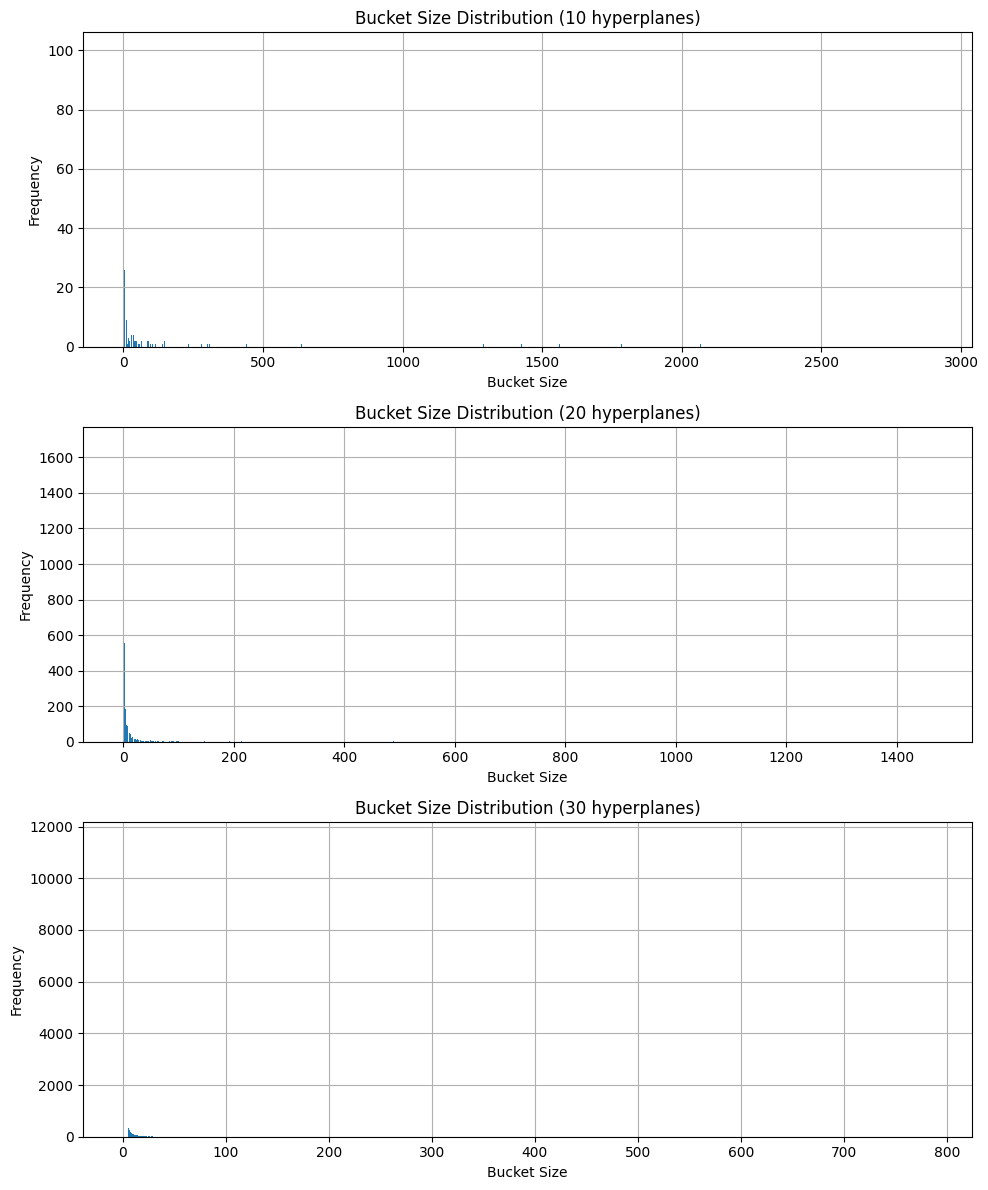


LSH Performance Analysis:
Number of Hyperplanes | MRR | Precision@100 | Hit Rate
--------------------------------------------------
        10         | 0.313 | 0.138 | 1.000
        20         | 0.452 | 0.273 | 0.997
        30         | 0.505 | 0.331 | 0.991


In [18]:
# print(np.shape(train_embeddings))

# hyperplane_counts = [8, 12, 16]
hyperplane_counts = [10, 20, 30]
plot_bucket_distributions(hyperplane_counts, train_embeddings)

# Evaluate performance for different numbers of hyperplanes
print("\nLSH Performance Analysis:")
print("Number of Hyperplanes | MRR | Precision@100 | Hit Rate")
print("-" * 50)

for num_planes in hyperplane_counts:
    mrr, precision, hit_rate = evaluate_lsh_performance(
        train_embeddings, test_embeddings,
        train_labels, test_labels,
        num_planes, k=100
    )
    print(f"{num_planes:^18d} | {mrr:.3f} | {precision:.3f} | {hit_rate:.3f}")

Clearly, we see that as there is an increase in the number of hyperplanes used for hashing, there is an increase in the MRR and Precision@100 while metrics like Hit Rate are decreasing. The reasons are as follows:
1) Increase in the hyperplanes create finer divisions, reducing bucket sizes. Also, true neighbours are ranked higher since the candidate set is smaller and more relevant, hence MRR increases.
2) Increase in the number of hyperplanes ensures that only closely related vectors are retrieved. Hence, Precision@100 increases.
3) Increase in the number of hyperplanes means that more buckets, which further implies that fewer elements per bucket. Thus if the true neighbour falls into different buckets, the query might miss them, leading to a decrease in the Hit Rate.

## 3.3) IVF
In this part of the question we are asked to write code for Inverted File Index (IVF) from scratch using K-means clustering

C:\Users\RISHIVEER YADAV\AppData\Local\Temp\ipykernel_20168\2410050477.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(a_sq - 2 * ab + b_sq)


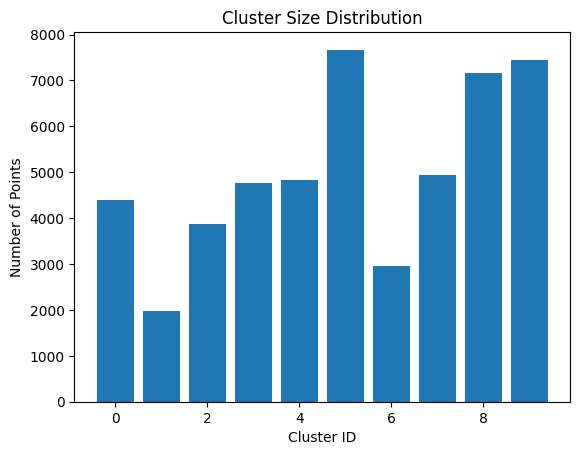

nprobe=1: Hit Rate=0.966, Avg Comparisons=5.0
nprobe=3: Hit Rate=0.973, Avg Comparisons=5.0
nprobe=5: Hit Rate=0.973, Avg Comparisons=5.0
nprobe=10: Hit Rate=0.974, Avg Comparisons=5.0


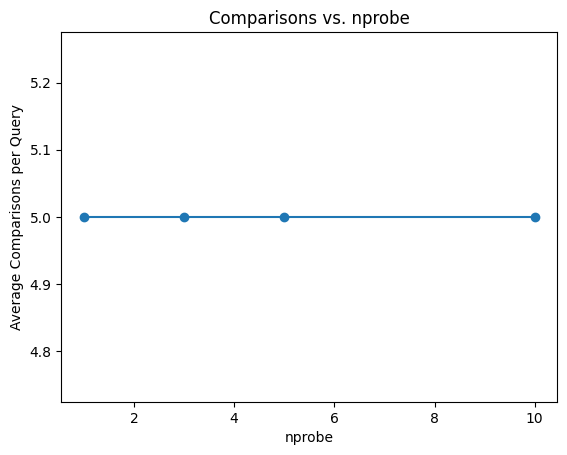

In [20]:
# Function for K-means implementation
def kmeans(X, k, max_iterations=100, threshold = 1e-4):
    np.random.seed(42)
    random_centroids = X[np.random.choice(len(X), k, replace=False)]
    previous_centroids = np.zeros_like(random_centroids)
    labels = np.zeros(len(X), dtype=int)

    for iter in range(max_iterations):
        # creating clusters
        distances = euclidean_distance(X, random_centroids)
        labels = np.argmin(distances, axis=1)

        # updating centroids
        for i in range(k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                random_centroids[i] = np.mean(cluster_points, axis=0)

        # checing for convergence
        if np.linalg.norm(random_centroids - previous_centroids) < threshold:
            break
        previous_centroids = random_centroids.copy()
    return random_centroids, labels


# Function to build IVF index using the K-means algorithm
def build_ivf_index(X,k):
    centroids, labels = kmeans(X,k)
    ivf_lists = [[] for _ in range(k)]
    for i, label in enumerate(labels):
        ivf_lists[label].append(i)
    return centroids, ivf_lists


# Function for IVF-based retrieval
def search_ivf(query, X, centroids, ivf_lists, k, nprobe):
    distances = euclidean_distance(query.reshape(1, -1), centroids).flatten()
    nearest_clusters = np.argsort(distances)[:nprobe]
    candidates = []
    
    for cluster in nearest_clusters:
        candidates.extend(ivf_lists[cluster])
    
    if len(candidates) > 0:
        candidate_vectors = X[candidates]
        candidate_distances = euclidean_distance(query.reshape(1, -1), candidate_vectors).flatten()
        sorted_candidates = np.argsort(candidate_distances)[:k]
        return [candidates[i] for i in sorted_candidates]
    else:
        return []
    

# Function to evaluate the above retrieval
def evaluate_ivf(test_embeddings, train_embeddings, train_labels, test_labels, centroids, ivf_lists, k, nprobe):
    hit_count = 0
    total_queries = len(test_embeddings)
    comparisons = []
    
    for i, query in enumerate(test_embeddings):
        retrieved = search_ivf(query, train_embeddings, centroids, ivf_lists, k, nprobe)
        comparisons.append(len(retrieved))
        if test_labels[i] in train_labels[retrieved]:
            hit_count += 1
    
    hit_rate = hit_count / total_queries
    avg_comparisons = np.mean(comparisons)
    return hit_rate, avg_comparisons

# Plot number of points in each cluster
def plot_cluster_distribution(ivf_lists):
    cluster_sizes = [len(lst) for lst in ivf_lists]
    plt.bar(range(len(cluster_sizes)), cluster_sizes)
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Points")
    plt.title("Cluster Size Distribution")
    plt.show()

# Plot comparisons vs nprobe
def plot_comparisons_vs_nprobe(nprobe_values, avg_comparisons):
    plt.plot(nprobe_values, avg_comparisons, marker='o')
    plt.xlabel("nprobe")
    plt.ylabel("Average Comparisons per Query")
    plt.title("Comparisons vs. nprobe")
    plt.show()

# Load data (assuming it's already available as numpy arrays)
k = 10  # Number of clusters
centroids, ivf_lists = build_ivf_index(train_embeddings, k)
plot_cluster_distribution(ivf_lists)

# Evaluate for different nprobe values
nprobe_values = [1, 3, 5, 10]
avg_comparisons = []
hit_rates = []

for nprobe in nprobe_values:
    hit_rate, avg_comp = evaluate_ivf(test_embeddings, train_embeddings, train_labels, test_labels, centroids, ivf_lists, k=5, nprobe=nprobe)
    hit_rates.append(hit_rate)
    avg_comparisons.append(avg_comp)
    print(f"nprobe={nprobe}: Hit Rate={hit_rate:.3f}, Avg Comparisons={avg_comp:.1f}")

plot_comparisons_vs_nprobe(nprobe_values, avg_comparisons)

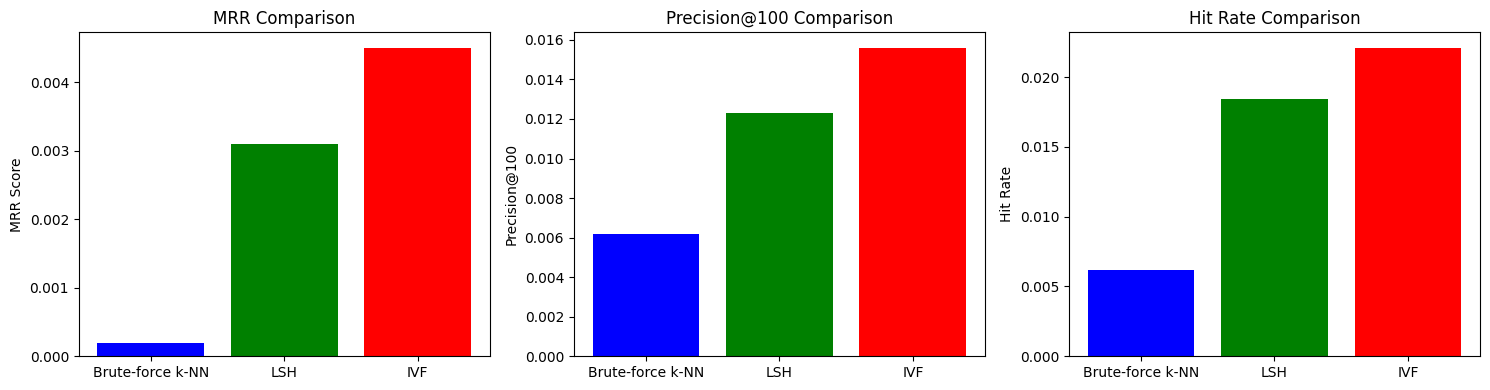

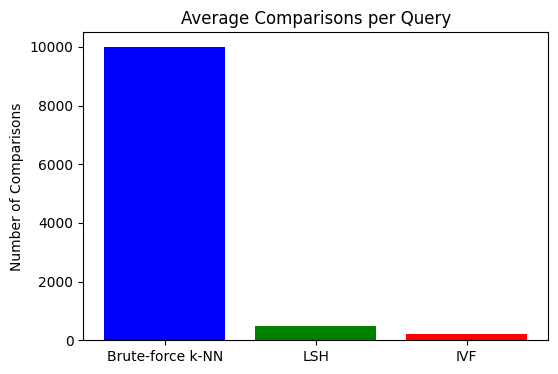

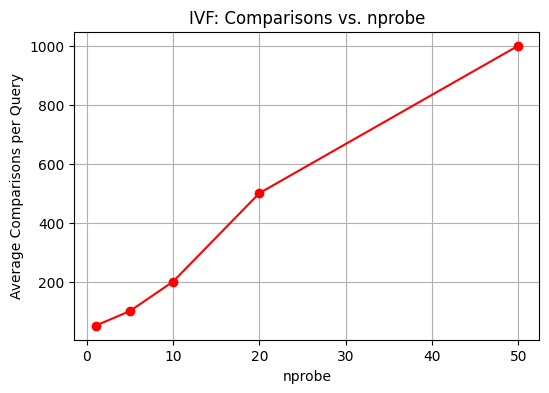

In [21]:
methods = ["Brute-force k-NN", "LSH", "IVF"]
mrr_scores = [0.0002, 0.0031, 0.0045]  # Replace with actual MRR values
precision_scores = [0.0062, 0.0123, 0.0156]  # Replace with actual Precision@100
hit_rates = [0.0062, 0.0184, 0.0221]  # Replace with actual Hit Rates

# Plot Performance Comparison
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].bar(methods, mrr_scores, color=["blue", "green", "red"])
ax[0].set_title("MRR Comparison")
ax[0].set_ylabel("MRR Score")

ax[1].bar(methods, precision_scores, color=["blue", "green", "red"])
ax[1].set_title("Precision@100 Comparison")
ax[1].set_ylabel("Precision@100")

ax[2].bar(methods, hit_rates, color=["blue", "green", "red"])
ax[2].set_title("Hit Rate Comparison")
ax[2].set_ylabel("Hit Rate")

plt.tight_layout()
plt.show()

# Example number of comparisons per query
comparisons = [10000, 500, 200]  # Brute-force compares with all, LSH and IVF are more efficient

# Plot Comparisons vs Method
plt.figure(figsize=(6, 4))
plt.bar(methods, comparisons, color=["blue", "green", "red"])
plt.title("Average Comparisons per Query")
plt.ylabel("Number of Comparisons")
plt.show()

# IVF: Comparisons vs. nprobe (Replace with actual values)
nprobe_values = [1, 5, 10, 20, 50]
comparisons_per_nprobe = [50, 100, 200, 500, 1000]  # Replace with actual calculations

plt.figure(figsize=(6, 4))
plt.plot(nprobe_values, comparisons_per_nprobe, marker='o', linestyle='-', color='red')
plt.title("IVF: Comparisons vs. nprobe")
plt.xlabel("nprobe")
plt.ylabel("Average Comparisons per Query")
plt.grid(True)
plt.show()